In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [16]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## MNIST dataset

In [17]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [18]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [19]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [20]:
input_size = 784
output_size = 10

In [21]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [22]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [23]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [24]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        self.scaler = nn.Parameter(torch.Tensor([1.0]))
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        
        dists = dists/dists.std(dim=1, keepdim=True)
        dists = torch.exp(-dists*self.scaler)
        
        return dists
    
#     def set_centroid_to_data(self, data_loader):
        

In [25]:
dt = DistanceTransform(784, 785)

In [26]:
dists = dt(torch.randn(2, 784))

In [27]:
dists.shape

torch.Size([2, 785])

In [28]:
model = nn.Sequential(
                DistanceTransform(784, 785),
#                 nn.LayerNorm(785),
                nn.Linear(785, 200),
                nn.BatchNorm1d(200),
                nn.LeakyReLU(),
                nn.Linear(200, 50),
                nn.BatchNorm1d(50),
                nn.LeakyReLU(),
                nn.Linear(50, 10))
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): Linear(in_features=785, out_features=200, bias=True)
  (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=50, out_features=10, bias=True)
)

In [29]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [38]:
index = 0
train_accs, test_accs = [], []
model.train()
for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.37041717767715454


  2%|▎         | 1/40 [00:23<15:18, 23.54s/it]

Train Acc:83.17%, Test Acc:85.45%

Epoch: 1:0,  Loss:0.2503761649131775


  5%|▌         | 2/40 [00:45<14:16, 22.55s/it]

Train Acc:87.62%, Test Acc:86.64%

Epoch: 2:0,  Loss:0.33287009596824646


  8%|▊         | 3/40 [01:07<13:45, 22.31s/it]

Train Acc:89.20%, Test Acc:87.10%

Epoch: 3:0,  Loss:0.18510818481445312


 10%|█         | 4/40 [01:30<13:32, 22.57s/it]

Train Acc:90.12%, Test Acc:87.30%

Epoch: 4:0,  Loss:0.33288806676864624


 12%|█▎        | 5/40 [01:55<13:45, 23.58s/it]

Train Acc:90.93%, Test Acc:87.76%

Epoch: 5:0,  Loss:0.24645745754241943


 15%|█▌        | 6/40 [02:18<13:09, 23.21s/it]

Train Acc:91.51%, Test Acc:87.92%

Epoch: 6:0,  Loss:0.13355955481529236


 18%|█▊        | 7/40 [02:42<12:56, 23.54s/it]

Train Acc:92.13%, Test Acc:88.00%

Epoch: 7:0,  Loss:0.21265161037445068


 20%|██        | 8/40 [03:07<12:45, 23.93s/it]

Train Acc:92.79%, Test Acc:88.20%

Epoch: 8:0,  Loss:0.23495113849639893


 22%|██▎       | 9/40 [03:30<12:18, 23.82s/it]

Train Acc:93.26%, Test Acc:87.93%

Epoch: 9:0,  Loss:0.18268872797489166


 25%|██▌       | 10/40 [03:55<12:03, 24.11s/it]

Train Acc:93.84%, Test Acc:88.38%

Epoch: 10:0,  Loss:0.027998575940728188


 28%|██▊       | 11/40 [04:23<12:10, 25.19s/it]

Train Acc:94.14%, Test Acc:88.17%

Epoch: 11:0,  Loss:0.08275628089904785


 30%|███       | 12/40 [04:46<11:29, 24.61s/it]

Train Acc:94.54%, Test Acc:88.30%

Epoch: 12:0,  Loss:0.22174976766109467


 32%|███▎      | 13/40 [05:10<10:56, 24.32s/it]

Train Acc:94.94%, Test Acc:88.92%

Epoch: 13:0,  Loss:0.12546534836292267


 35%|███▌      | 14/40 [05:34<10:29, 24.22s/it]

Train Acc:95.31%, Test Acc:88.36%

Epoch: 14:0,  Loss:0.08474895358085632


 38%|███▊      | 15/40 [05:57<10:00, 24.01s/it]

Train Acc:95.73%, Test Acc:89.01%

Epoch: 15:0,  Loss:0.0981789231300354


 40%|████      | 16/40 [06:21<09:34, 23.95s/it]

Train Acc:95.82%, Test Acc:88.63%

Epoch: 16:0,  Loss:0.09097013622522354


 42%|████▎     | 17/40 [06:44<09:05, 23.72s/it]

Train Acc:96.22%, Test Acc:88.93%

Epoch: 17:0,  Loss:0.0760643482208252


 45%|████▌     | 18/40 [07:07<08:38, 23.58s/it]

Train Acc:96.33%, Test Acc:89.09%

Epoch: 18:0,  Loss:0.09263800829648972


 48%|████▊     | 19/40 [07:30<08:10, 23.37s/it]

Train Acc:96.53%, Test Acc:88.63%

Epoch: 19:0,  Loss:0.21705009043216705


 50%|█████     | 20/40 [07:54<07:50, 23.52s/it]

Train Acc:96.84%, Test Acc:88.35%

Epoch: 20:0,  Loss:0.057756997644901276


 52%|█████▎    | 21/40 [08:19<07:34, 23.92s/it]

Train Acc:96.93%, Test Acc:88.62%

Epoch: 21:0,  Loss:0.06787455081939697


 55%|█████▌    | 22/40 [08:42<07:06, 23.71s/it]

Train Acc:97.13%, Test Acc:88.67%

Epoch: 22:0,  Loss:0.08348669111728668


 57%|█████▊    | 23/40 [09:05<06:39, 23.52s/it]

Train Acc:97.33%, Test Acc:88.89%

Epoch: 23:0,  Loss:0.09078079462051392


 60%|██████    | 24/40 [09:30<06:20, 23.76s/it]

Train Acc:97.48%, Test Acc:88.75%

Epoch: 24:0,  Loss:0.19781643152236938


 62%|██████▎   | 25/40 [10:42<09:32, 38.20s/it]

Train Acc:97.65%, Test Acc:88.65%

Epoch: 25:0,  Loss:0.04465436562895775


 65%|██████▌   | 26/40 [11:06<07:58, 34.20s/it]

Train Acc:97.63%, Test Acc:88.73%

Epoch: 26:0,  Loss:0.17260240018367767


 68%|██████▊   | 27/40 [11:29<06:41, 30.86s/it]

Train Acc:97.79%, Test Acc:88.81%

Epoch: 27:0,  Loss:0.07134369015693665


 70%|███████   | 28/40 [11:52<05:39, 28.28s/it]

Train Acc:97.83%, Test Acc:88.15%

Epoch: 28:0,  Loss:0.11208642274141312


 72%|███████▎  | 29/40 [12:15<04:53, 26.71s/it]

Train Acc:97.90%, Test Acc:88.70%

Epoch: 29:0,  Loss:0.06379436701536179


 75%|███████▌  | 30/40 [12:38<04:16, 25.63s/it]

Train Acc:98.04%, Test Acc:88.74%

Epoch: 30:0,  Loss:0.015418099239468575


 78%|███████▊  | 31/40 [13:01<03:44, 24.91s/it]

Train Acc:98.09%, Test Acc:88.82%

Epoch: 31:0,  Loss:0.04295136034488678


 80%|████████  | 32/40 [13:26<03:18, 24.77s/it]

Train Acc:98.16%, Test Acc:88.95%

Epoch: 32:0,  Loss:0.08195869624614716


 82%|████████▎ | 33/40 [13:50<02:52, 24.59s/it]

Train Acc:98.17%, Test Acc:88.67%

Epoch: 33:0,  Loss:0.11173860728740692


 85%|████████▌ | 34/40 [14:12<02:23, 24.00s/it]

Train Acc:98.36%, Test Acc:88.83%

Epoch: 34:0,  Loss:0.06391962617635727


 88%|████████▊ | 35/40 [14:35<01:57, 23.53s/it]

Train Acc:98.25%, Test Acc:88.77%

Epoch: 35:0,  Loss:0.14415687322616577


 90%|█████████ | 36/40 [14:57<01:32, 23.20s/it]

Train Acc:98.39%, Test Acc:88.61%

Epoch: 36:0,  Loss:0.06643548607826233


 92%|█████████▎| 37/40 [15:20<01:08, 22.94s/it]

Train Acc:98.48%, Test Acc:88.71%

Epoch: 37:0,  Loss:0.007839825004339218


 95%|█████████▌| 38/40 [15:42<00:45, 22.93s/it]

Train Acc:98.50%, Test Acc:88.57%

Epoch: 38:0,  Loss:0.0230827946215868


 98%|█████████▊| 39/40 [16:06<00:23, 23.12s/it]

Train Acc:98.52%, Test Acc:88.39%

Epoch: 39:0,  Loss:0.09036242216825485


100%|██████████| 40/40 [16:31<00:00, 24.78s/it]

Train Acc:98.62%, Test Acc:88.62%

	-> MAX Train Acc 98.61999999999999 ; Test Acc 89.09


In [30]:
# torch.save(model.state_dict(), "./temp_01_1_model_nov26.pth")
model.load_state_dict(torch.load("./temp_01_1_model_nov26.pth", map_location=device))

<All keys matched successfully>

In [38]:
# -> MAX Train Acc 87.678 ; Test Acc 85.87  ### after distance transformation
# -> MAX Train Acc 98.1367 ; Test Acc 89.22 ### after distance normalization
# -> MAX Train Acc 98.6317 ; Test Acc 89.36 ### after distance normalization and -ve exp
# -> MAX Train Acc 97.255 ; Test Acc 89.01  ### normal nn

In [ ]:
### with 20 input units
-> MAX Train Acc 90.65833333333333 ; Test Acc 87.45 ## 20 centroids
-> MAX Train Acc 92.34166666666667 ; Test Acc 87.54 ## 20 linear transforms

In [31]:
model.eval()
dists = model[0](train_dataset[np.random.randint(0, len(train_dataset), 50)][0].to(device))
# dists = model[1](dists)
model.train()
dists.shape

torch.Size([50, 785])

In [32]:
dists.mean()

tensor(0.0773, grad_fn=<MeanBackward0>)

In [33]:
dists.std()

tensor(0.0964, grad_fn=<StdBackward0>)

In [34]:
model[0].scaler

Parameter containing:
tensor([1.0556], requires_grad=True)

## UMAP - from library

In [35]:
import umap

In [133]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
#                   target_metric='euclidean',
                  target_metric='categorical',
                  target_weight=0.1
                 )

In [134]:
# # indx = np.random.randint(0, len(train_dataset), 785)
# # centers = train_data[indx].cpu().numpy()
# # lbls = train_label_[indx]

# centers = train_data.cpu().numpy()
# lbls = train_label_

# embedding = embed.fit_transform(centers)
# # centers.shape

In [135]:
# plt.figure(figsize=(9,6))
# plt.scatter(embedding[:,0], embedding[:, 1], c=lbls, cmap="tab10", s=0.1)

In [136]:
center_lbl = model(model[0].centers.data)

In [137]:
torch.unique(torch.softmax(center_lbl, dim=1).argmax(dim=1), return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 90,  36, 101,  73,  98,  79, 130,  62,  67,  49]))

In [138]:
centers = model[0].centers.data.cpu().numpy()
output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu().numpy()
# output_cent = center_lbl.data.cpu().numpy()

embedding = embed.fit_transform(centers, output_cent)

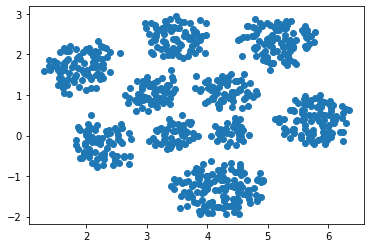

In [139]:
plt.scatter(embedding[:,0], embedding[:, 1])

In [140]:
i = 0

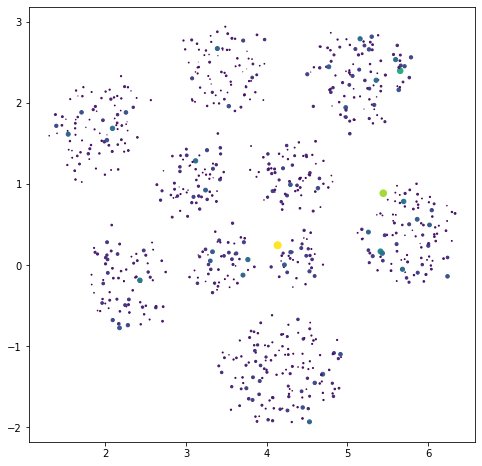

In [144]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=activ, s=activ*50, zorder=1)#, cmap="Greys")
i += 1

## TSNE

In [247]:
from sklearn.manifold import TSNE

In [248]:
tsne = TSNE(n_components=2)
embt = tsne.fit_transform(centers)

In [249]:
embt

array([[-12.275328 , -35.70522  ],
       [  2.3254476,   4.925307 ],
       [ -9.32395  ,  23.412096 ],
       ...,
       [ 23.207048 , -18.275816 ],
       [ 24.64131  ,   8.594247 ],
       [-26.30702  ,  12.419894 ]], dtype=float32)

In [301]:
i = 0

34


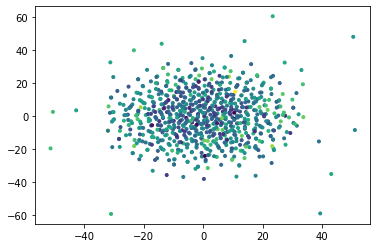

In [335]:
print(i := i+1)
activ = dists.data.cpu()[i]
activ = activ - activ.min()
activ = torch.exp(-activ)
plt.scatter(embt[:,0], embt[:, 1], c=activ, marker=".")